In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from configs import *
from FM_dataset import *
from FM_models import *
from FM_train import *
from FM_evaluate import *
from configs import *
from utils_CP_flows import *

import numpy as np
import pandas as pd
import itertools
from collections import defaultdict
import pickle
from tqdm import tqdm
from scipy.ndimage import zoom
import random
from multiprocessing import Pool
from functools import partial

set_seed(random_seed)
random.seed(random_seed)

2025-07-06 11:49:48.581705: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-06 11:49:48.623858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-06 11:49:49.203100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Evaluation

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = SharedMultiHeadVAE().to(device)
vae.load_state_dict(torch.load(f"{checkpoint_dir}/LatentVAE1_{size_crop}_{size_crop_resize}.pth"))
vae.eval()

SharedMultiHeadVAE(
  (encoder): VAEEncoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU()
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): AdaptiveAvgPool2d(output_size=(4, 4))
    )
    (fc_mu): Linear(in_features=4096, out_features=256, bias=True)
    (fc_logvar): Linear(in_features=4096, out_feature

In [3]:
def evaluate_testset(
    list_npz_files, 
    model=vae, device=device, 
    size_crop_resize=size_crop_resize, 
    batch_size = 256, 
):
    val_dataset = CellposeDataset(list_files=list_npz_files, size=size_crop_resize)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    val_trues = [[], [], []] #fx, fy, mask
    val_preds = [[], [], [], [], []] #fx, fy, mask, mu, logvar
    with torch.no_grad():
        for batch in tqdm(val_loader):
            inputs, fx, fy, rm = [x.to(device) for x in batch]
            preds = model(inputs)
            preds = [x.detach().cpu().numpy() for x in preds]
            for p, val_p in zip(preds, val_preds):
                val_p.append(p)
    
            for x,gt in zip([fx, fy, rm], val_trues):
                gt.append(x.detach().cpu().numpy())
    
    val_preds = [np.concatenate(p, axis=0) for p in val_preds]
    val_trues = [np.concatenate(p, axis=0) for p in val_trues]
    val_ids = val_dataset.files
    val_label_ids = [i.split('/')[-1].split('_roi_')[-1].split('.')[0] for i in val_ids]
    val_label_ids = [int(i) for i in val_label_ids]
    return val_trues, val_preds, val_label_ids

def generate_npz(image_path, dir_ds_te, return_output=False):
    img_name = image_path.split("/")[-1].split(".")[0]
    img = io.imread(image_path, as_gray=True,)
    
    ## randomly isolate ROI and its surrounding
    # segmentation by CP
    cp_output = segment_image(image_path)
    masks, props, img_rec = cp_output
    labels = filter_ROIs(cp_output, size_crop)

    # augment the full image
    tform = augmentation()
    cp_output_aug, k = augment_whole_slide(cp_output,tform)
    masks_aug, props_aug, img_rec_aug = cp_output_aug

    list_npz = []
    for label_id in tqdm(labels):
        x1, x2 = crop_stack_mask_original(cp_output, label_id)
        f_npz = f"{dir_ds_te}/{img_name}_roi_{label_id}.npz"
        np.savez_compressed(
            f_npz,
            flow_x=x1[...,0],
            flow_y=x1[...,1],
            cell_prob=x1[...,2],
            roi_mask=x2[...,0]
        )
        list_npz.append(f_npz)

    if return_output:
        return cp_output, labels, list_npz

In [4]:
img1 = "TA21c2-1"
img2 = "TA21c3-1"

dir_ds_te = "/DATA/fiber_matcher/datasets/npz_256_test"
images_dir = "/DATA/fiber_matcher/images/"

path_img1 = f"{images_dir}/{img1}.png"
path_img2 = f"{images_dir}/{img2}.png"

cp_output_1, labels_1, list_npz1 = generate_npz(path_img1, dir_ds_te, return_output=True)
cp_output_2, labels_2, list_npz2 = generate_npz(path_img2, dir_ds_te, return_output=True)

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 29.21it/s]


In [5]:
X_true_1, X_pred_1, label_ids_1 = evaluate_testset(list_npz1)
X_true_2, X_pred_2, label_ids_2 = evaluate_testset(list_npz2)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


In [6]:
l_mu_1 = {label_id:x_pred for label_id, x_pred in zip(label_ids_1, X_pred_1[3])}
l_mu_2 = {label_id:x_pred for label_id, x_pred in zip(label_ids_2, X_pred_2[3])}

In [7]:
dict_idx2labelid = {
    "img1": {i:label_id for i,label_id in enumerate(label_ids_1)},
    "img2": {i:label_id for i,label_id in enumerate(label_ids_2)},
}

dict_labelid2idx = {
    "img1": {label_id:i for i,label_id in enumerate(label_ids_1)},
    "img2": {label_id:i for i,label_id in enumerate(label_ids_2)},
}

In [8]:
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

In [9]:
def matrix_distance_centroids(cp_output, labels):
    masks, props, img_rec = cp_output
    assert [region.label for region in props if region.label in labels] == labels
    centroids = np.array([region.centroid for region in props if region.label in labels])
    D = cdist(centroids, centroids, metric='euclidean')
    return D
    
def compute_knn_signature(D, k=5):
    """
    For each row i in D (with D[i,i]=0), return the k smallest non-zero distances,
    sorted.  Shape: (num_points, k).
    """
    n = D.shape[0]
    sig = np.zeros((n, k), dtype=D.dtype)
    for i in range(n):
        # get all other distances
        d_i = np.delete(D[i], i)
        # take the k smallest
        knn = np.partition(d_i, k)[:k]
        sig[i] = np.sort(knn)
    return sig

def build_cost_matrix(E1, E2, D1, D2, lambda_spatial=1.0, k=5):
    """
    E1: (n, d) embeddings for image1
    E2: (m, d) embeddings for image2
    D1: (n, n) pairwise distances in image1
    D2: (m, m) pairwise distances in image2
    returns: cost C of shape (n, m)
    """
    n, d = E1.shape
    m, _ = E2.shape

    # 1) embedding‐distance term
    #    broadcasting: ||E1[i] - E2[j]||
    diff = E1[:, None, :] - E2[None, :, :]        # (n, m, d)
    emb_dist = np.linalg.norm(diff, axis=2)       # (n, m)
    
    # 2) spatial‐signature term
    V1 = compute_knn_signature(D1, k=k)           # (n, k)
    V2 = compute_knn_signature(D2, k=k)           # (m, k)
    # expand for pairwise norm
    v1_exp = V1[:, None, :]                       # (n,1,k)
    v2_exp = V2[None, :, :]                       # (1,m,k)
    spatial_dist = np.linalg.norm(v1_exp - v2_exp, axis=2)  # (n, m)
    
    # combine
    C = emb_dist + lambda_spatial * spatial_dist
    return C

def match_rois(E1, E2, D1, D2, lambda_spatial=1.0, k=5, cost_threshold=None):
    """
    Returns a list of matched (i,j) pairs.
    Optionally drop any match whose cost > cost_threshold.
    """
    C = build_cost_matrix(E1, E2, D1, D2, lambda_spatial, k)
    row_idx, col_idx = linear_sum_assignment(C)
    
    matches = []
    for i, j in zip(row_idx, col_idx):
        if cost_threshold is None or C[i, j] <= cost_threshold:
            matches.append((i, j, C[i, j]))
    return matches

In [10]:
label_ids_1

[13, 14, 15, 19, 20, 22, 23, 26, 27, 30, 31, 35, 36, 38, 39, 40, 43, 44]

In [11]:
D1 = matrix_distance_centroids(cp_output_1, labels_1)
D2 = matrix_distance_centroids(cp_output_2, labels_2)

In [12]:
E1 = np.array([x for x in X_pred_1[3]])
E2 = np.array([x for x in X_pred_2[3]])

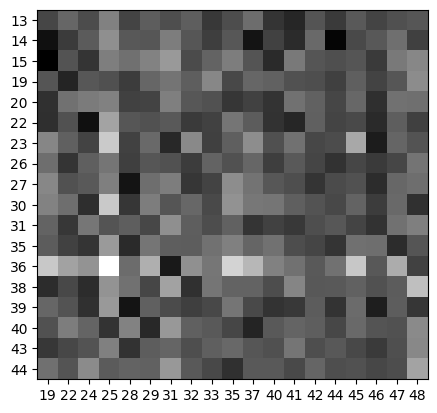

In [14]:
diff = E1[:, None, :] - E2[None, :, :]        # (n, m, d)
matrix_similarity = np.mean(diff**2, axis=2)       # (n, m)

plt.imshow(matrix_similarity, cmap="gray", )
plt.xticks(ticks=np.arange(len(label_ids_2)), labels=list(dict_idx2labelid["img2"].values()))
plt.yticks(ticks=np.arange(len(label_ids_1)), labels=list(dict_idx2labelid["img1"].values()))
plt.show()

In [54]:
label_roi1 = 38
k=3

label_roi1_idx = dict_labelid2idx["img1"][label_roi1]
neighbor_roi1_ids = np.argsort(D1[label_roi1_idx])[1:k+1]
neighbor_roi1_labels = [dict_idx2labelid["img1"][i] for i in neighbor_roi1_ids]

for label_roi2 in [45,42,33,32,41,47,25,22]:
    label_roi2_idx = dict_labelid2idx["img2"][label_roi2]
    neighbor_roi2_ids = np.argsort(D1[label_roi2_idx])[1:k+1]
    neighbor_roi2_labels = [dict_idx2labelid["img2"][i] for i in neighbor_roi2_ids]

    score_roi = matrix_similarity[label_roi1_idx, label_roi2_idx]
    score_neighbors = matrix_similarity[neighbor_roi1_ids, neighbor_roi2_ids].mean()
    print(f'{label_roi2}: {score_roi}, {score_neighbors}')

45: 0.12587226927280426, 0.11380372196435928
42: 0.12123863399028778, 0.12307541817426682
33: 0.13490663468837738, 0.1084839478135109
32: 0.10216832160949707, 0.12175822257995605
41: 0.14301824569702148, 0.12819190323352814
47: 0.12299637496471405, 0.12101507186889648
25: 0.1494533121585846, 0.13007976114749908
22: 0.11316417157649994, 0.12037992477416992


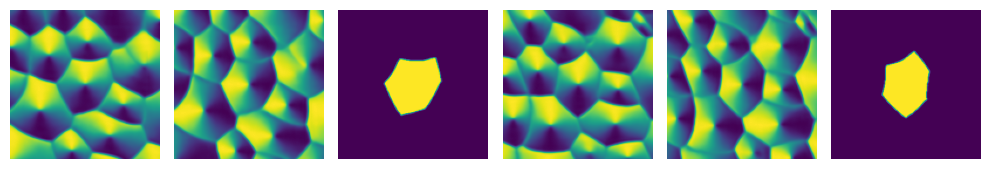

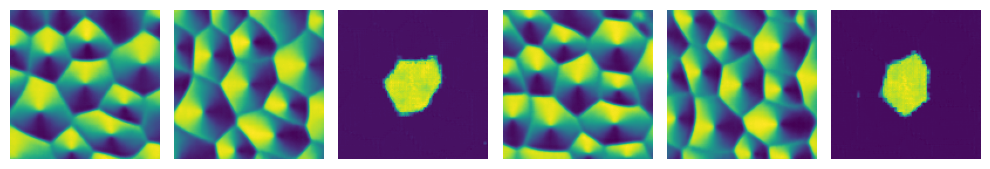

In [69]:
plot_prediction(X_true_1, X_true_2, X_pred_1, X_pred_2, idx_roi1=26, idx_roi2=33, dict_labelid2idx=dict_labelid2idx)

In [67]:
def plot_prediction(X_true_1, X_true_2, X_pred_1, X_pred_2, idx_roi1, idx_roi2, dict_labelid2idx):
    _, axs = plt.subplots(1, 6, figsize=(10,4))
    
    # img1
    axs[0].imshow(X_true_1[0][dict_labelid2idx["img1"][idx_roi1],0,...])
    axs[0].axis('off')
    
    axs[1].imshow(X_true_1[1][dict_labelid2idx["img1"][idx_roi1],0,...])
    axs[1].axis('off')
    
    axs[2].imshow(X_true_1[2][dict_labelid2idx["img1"][idx_roi1],0,...])
    axs[2].axis('off')
    
    # img2
    axs[3].imshow(X_true_2[0][dict_labelid2idx["img2"][idx_roi2],0,...])
    axs[3].axis('off')
    
    axs[4].imshow(X_true_2[1][dict_labelid2idx["img2"][idx_roi2],0,...])
    axs[4].axis('off')
    
    axs[5].imshow(X_true_2[2][dict_labelid2idx["img2"][idx_roi2],0,...])
    axs[5].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    
    _, axs = plt.subplots(1, 6, figsize=(10,4))
    
    # img1
    axs[0].imshow(X_pred_1[0][dict_labelid2idx["img1"][idx_roi1],0,...])
    axs[0].axis('off')
    
    axs[1].imshow(X_pred_1[1][dict_labelid2idx["img1"][idx_roi1],0,...])
    axs[1].axis('off')
    
    axs[2].imshow(X_pred_1[2][dict_labelid2idx["img1"][idx_roi1],0,...])
    axs[2].axis('off')
    
    # img2
    axs[3].imshow(X_pred_2[0][dict_labelid2idx["img2"][idx_roi2],0,...])
    axs[3].axis('off')
    
    axs[4].imshow(X_pred_2[1][dict_labelid2idx["img2"][idx_roi2],0,...])
    axs[4].axis('off')
    
    axs[5].imshow(X_pred_2[2][dict_labelid2idx["img2"][idx_roi2],0,...])
    axs[5].axis('off')
    
    plt.tight_layout()
    plt.show()